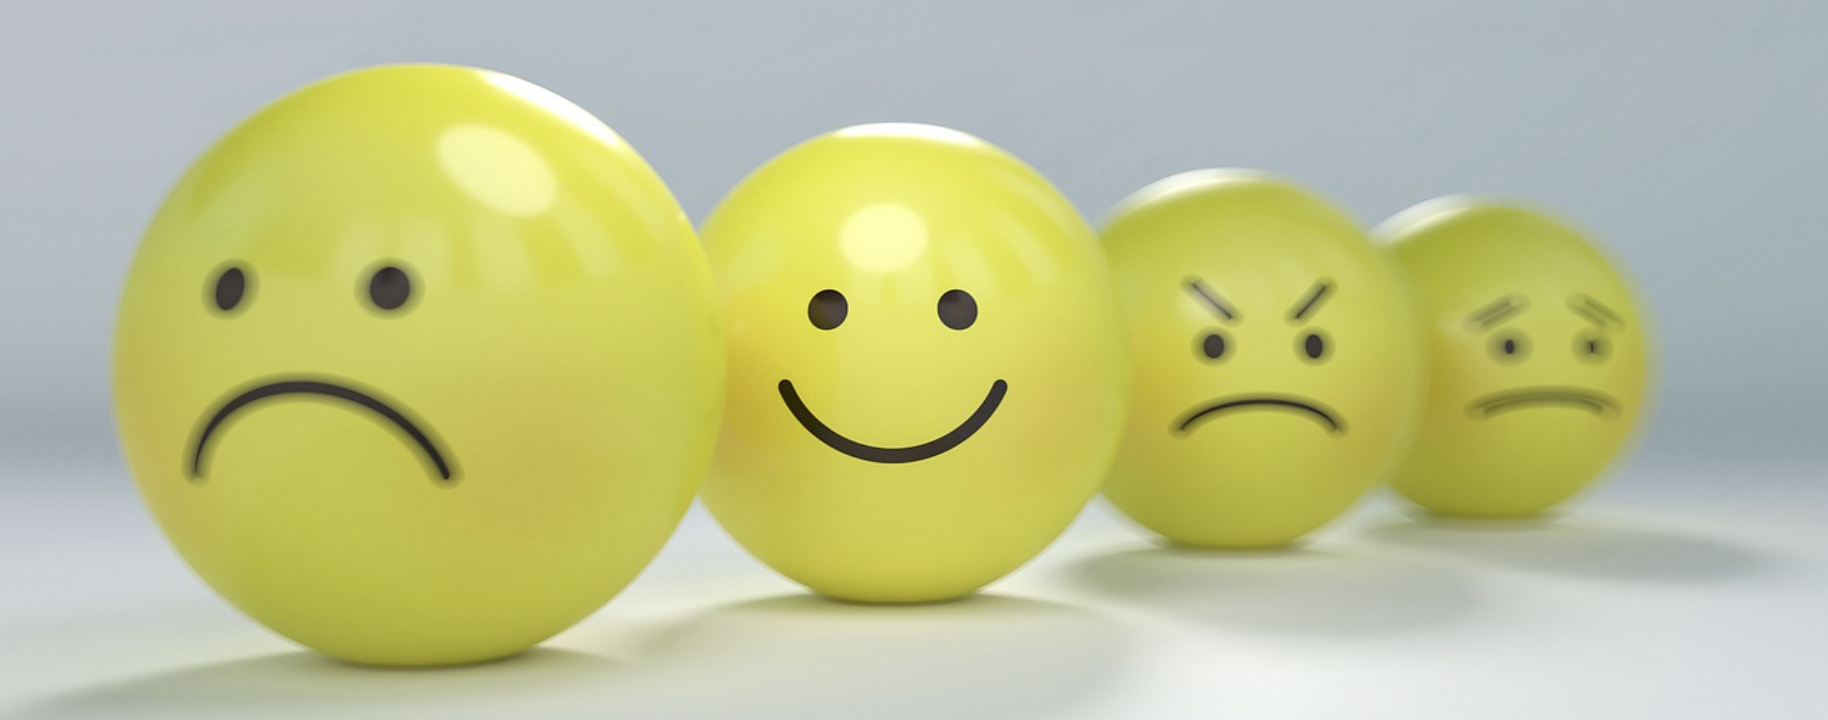

# Exploration 8. Sentimental Classification
---
# (프로젝트) 네이버 영화리뷰 감성분석 도전하기

## [루브릭]
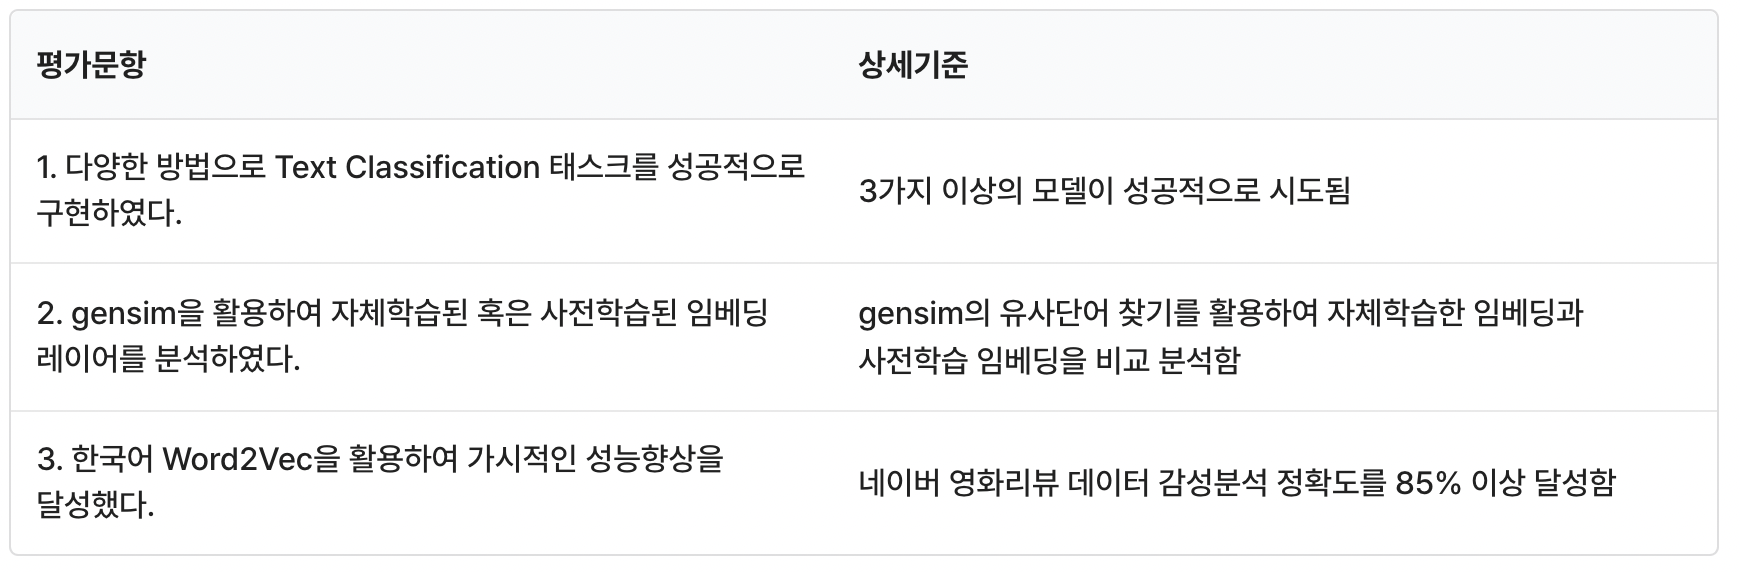

## 0) 주요 라이브러리 import

In [1]:
import pandas
import konlpy
import gensim
import numpy as np

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.5.2
0.6.0
4.2.0


## 1) 데이터 준비와 확인

In [2]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('/Users/joowanha/PycharmProjects/AIFFEL/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('/Users/joowanha/PycharmProjects/AIFFEL/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [4]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


Naver sentiment movie corpus의 원문을 보면 label: The sentiment class of the review. (0: negative, 1: positive) 로 표시된다고 했습니다. 그런데 train_data의 일부만 확인해 봐도 (상기 1~2번 index 참고) 부정이 긍정으로, 긍정이 부정으로 표시된 것이 보입니다.   
좀 더 정확한 감정 분석을 위해서는 label 값이 정합도가 좀 더 높아야 할 것으로 판단되는 데 일단 해당 내용을 감안하고 진행하도록 하겠습니다.

## 2) 데이터로더 구성

### 2.1) 데이터 중복 및 결측치 제거

In [5]:
train_data['document'].duplicated().sum()

3817

In [6]:
test_data['document'].duplicated().sum()

842

In [7]:
train_data.drop_duplicates(subset=['document'], inplace=True)

In [8]:
test_data.drop_duplicates(subset=['document'], inplace=True)

In [9]:
train_data['document'].duplicated().sum()

0

In [10]:
test_data['document'].duplicated().sum()

0

In [11]:
train_data.isnull().sum()

id          0
document    1
label       0
dtype: int64

In [12]:
test_data.isnull().sum()

id          0
document    1
label       0
dtype: int64

In [13]:
train_data.loc[train_data['document'].isnull()]

,id,document,label
25857,2172111,NaN,1


In [14]:
train_data.dropna(subset=['document'], inplace=True) 

In [15]:
train_data.isnull().sum()

id          0
document    0
label       0
dtype: int64

In [16]:
test_data.loc[test_data['document'].isnull()]

,id,document,label
5746,402110,NaN,1


In [17]:
test_data.dropna(subset=['document'], inplace=True) 

In [18]:
test_data.isnull().sum()

id          0
document    0
label       0
dtype: int64

In [19]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146182 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        146182 non-null  int64 
 1   document  146182 non-null  object
 2   label     146182 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.5+ MB


In [20]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49157 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        49157 non-null  int64 
 1   document  49157 non-null  object
 2   label     49157 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


### 2.2) 정규화를 통한 데이터 정제

In [21]:
# 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5]

/var/folders/5f/hvh_0cjn23gb8801jkdrsc540000gn/T/ipykernel_26413/3525229848.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [22]:
train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id            0
document    789
label         0
dtype: int64


/var/folders/5f/hvh_0cjn23gb8801jkdrsc540000gn/T/ipykernel_26413/2260017223.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경


In [23]:
train_data.loc[train_data.document.isnull()][:5]

,id,document,label
404,4221289,NaN,0
412,9509970,NaN,1
470,10147571,NaN,1
584,7117896,NaN,0
593,6478189,NaN,0


한글 외 글자를 제거하니 null 값을 가진 데이터가 추가되었습니다. 해당 데이터도 의미가 없으니 제거하도록 하겠습니다.

In [24]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

145393


test 데이터도 동일하게 처리하도록 하겠습니다.

In [25]:
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['document'] = test_data['document'].str.replace('^ +', "")
test_data['document'].replace('', np.nan, inplace=True)
test_data = test_data.dropna(how='any') 
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48852


/var/folders/5f/hvh_0cjn23gb8801jkdrsc540000gn/T/ipykernel_26413/2643035547.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
/var/folders/5f/hvh_0cjn23gb8801jkdrsc540000gn/T/ipykernel_26413/2643035547.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace('^ +', "")


<AxesSubplot: >

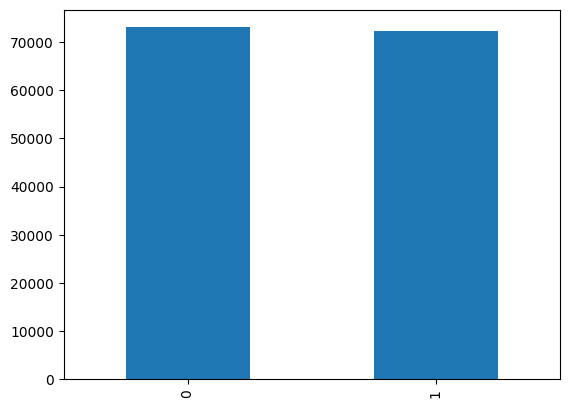

In [26]:
train_data['label'].value_counts().plot(kind = 'bar')

train 데이터의 긍부정 라벨은 유사한 비율로 나와 있는 것을 확인할 수 있습니다.

### 2.3) 한국어 토크나이저로 토큰화

In [27]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

In [28]:
train_data['document']

0                                         아 더빙 진짜 짜증나네요 목소리
1                                흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나
2                                         너무재밓었다그래서보는것을추천한다
3                                 교도소 이야기구먼 솔직히 재미는 없다평점 조정
4         사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...
                                ...                        
149995                                      인간이 문제지 소는 뭔죄인가
149996                                           평점이 너무 낮아서
149997                        이게 뭐요 한국인은 거들먹거리고 필리핀 혼혈은 착하다
149998                           청춘 영화의 최고봉방황과 우울했던 날들의 자화상
149999                             한국 영화 최초로 수간하는 내용이 담긴 영화
Name: document, Length: 145393, dtype: object

In [29]:
tokenizer = Mecab()
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다']

In [30]:
def load_data(train_data, test_data, num_words=10000):
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_train.append(temp_X)
    
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4)
    vocab = [''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab, start=3)}
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index        

In [31]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [32]:
y_train.shape

(145393,)

In [33]:
len(X_train)

145393

In [34]:
X_train[:3]

[[27, 67, 895, 33, 214, 15, 28, 699],
 [977, 481, 491, 636, 4, 110, 1554, 48, 864, 949, 11, 38, 364],
 [19, 192, 3]]

In [35]:
# word_to_index 추가
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2 

In [36]:
index_to_word = {index : word for word, index in word_to_index.items()}

In [37]:
# 문장 1개를 활용할 딕션너리와 함께 주면 단어 인덱스 리스트 벡터로 변환해 주는 함수
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

In [38]:
# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode 해주는 함수
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

In [39]:
# 숫자 벡터로 encode된 문장을 원래대로 decode 하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:]) # <BOS> 제외 

In [40]:
# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3) 모델 구성을 위한 데이터 분석 및 가공

In [41]:
num_tokens = [len(tokens) for tokens in X_train]
num_tokens = np.array(num_tokens)

In [42]:
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  13.800114173309582
문장길이 최대 :  83
문장길이 표준편차 :  11.438579116267315


In [43]:
# 최대 길이를 (평균 + 2*표준편차)로 수행
max_tokens = np.mean(num_tokens) + 2*np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequence maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens)/len(num_tokens)))

pad_sequence maxlen :  36
전체 문장의 0.9335456314953264%가 maxlen 설정값 이내에 포함됩니다. 


In [44]:
import matplotlib.pyplot as plt

문장 최대 길이 : 83
문장 평균 길이 : 13.800114173309582


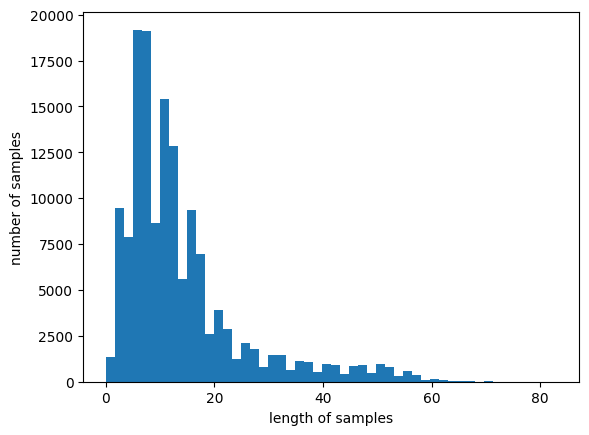

In [45]:
print('문장 최대 길이 :',max(len(tokens) for tokens in X_train))
print('문장 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(tokens) for tokens in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [46]:
import tensorflow as tf

In [47]:
X_train_pre = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test_pre = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train_pre.shape)

(145393, 36)


## 4) 모델링 및 훈련

In [48]:
# validation set 10000건 분리
X_val = X_train_pre[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지
partial_X_train = X_train_pre[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(135393, 36)
(135393,)


### 4.1) 1st Model

In [50]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 6, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 6, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 conv1d (Conv1D)             (None, None, 16)          1552      
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 16)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 16)          1552      
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 8)                

In [180]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=2)

Epoch 1/20


2022-12-07 00:31:19.512856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-07 00:31:35.600261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


265/265 - 17s - loss: 0.4992 - accuracy: 0.7552 - val_loss: 0.3789 - val_accuracy: 0.8212 - 17s/epoch - 63ms/step
Epoch 2/20
265/265 - 14s - loss: 0.3533 - accuracy: 0.8439 - val_loss: 0.3643 - val_accuracy: 0.8355 - 14s/epoch - 54ms/step
Epoch 3/20
265/265 - 14s - loss: 0.3196 - accuracy: 0.8617 - val_loss: 0.3627 - val_accuracy: 0.8342 - 14s/epoch - 55ms/step
Epoch 4/20
265/265 - 14s - loss: 0.2903 - accuracy: 0.8765 - val_loss: 0.3730 - val_accuracy: 0.8325 - 14s/epoch - 54ms/step
Epoch 5/20
265/265 - 14s - loss: 0.2593 - accuracy: 0.8928 - val_loss: 0.3888 - val_accuracy: 0.8321 - 14s/epoch - 54ms/step
Epoch 6/20
265/265 - 14s - loss: 0.2273 - accuracy: 0.9086 - val_loss: 0.4160 - val_accuracy: 0.8252 - 14s/epoch - 53ms/step
Epoch 7/20
265/265 - 14s - loss: 0.1976 - accuracy: 0.9230 - val_loss: 0.4657 - val_accuracy: 0.8164 - 14s/epoch - 53ms/step
Epoch 8/20
265/265 - 14s - loss: 0.1719 - accuracy: 0.9349 - val_loss: 0.4874 - val_accuracy: 0.8166 - 14s/epoch - 53ms/step
Epoch 9/20


In [181]:
results = model.evaluate(X_test_pre,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.9665 - accuracy: 0.7937 - 4s/epoch - 2ms/step
[0.9664638042449951, 0.7937424778938293]


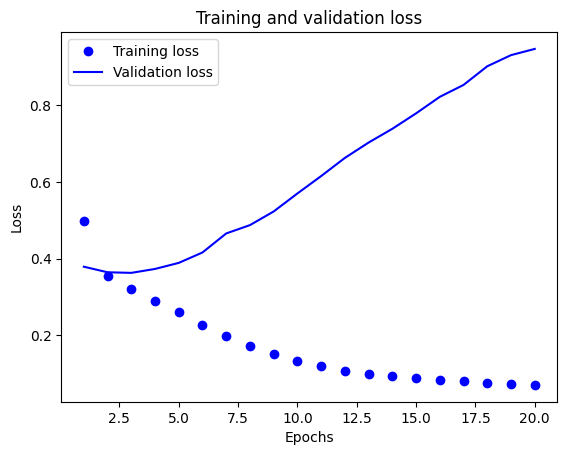

In [182]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss, 'bo', label='Training loss') # "bo"는 "파란색 점"
plt.plot(epochs, val_loss, 'b', label='Validation loss') # b는 "파란 실선"
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

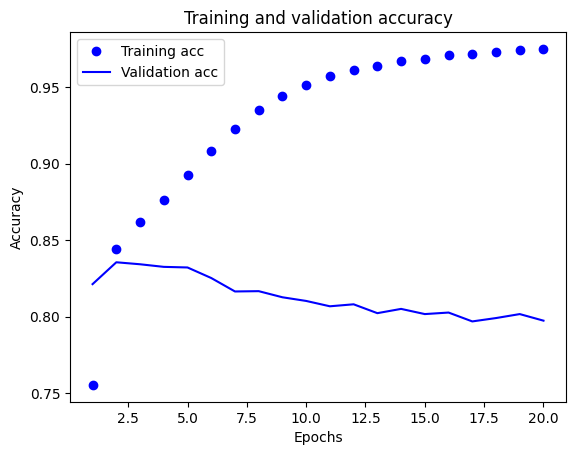

In [183]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

상기 그래프를 보면 train accuracy는 잘 상승하였는데, validation accuracy는 오히려 하강하는 것이 확인됩니다. 해당 학습이 training에 과적합된 것이 아닌지 의심하여 overfitting을 제거할 수 있도록 추가 수정해 보도록 하겠습니다.

### 4.2) 2nd Model

In [201]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 60  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model_2nd = tf.keras.Sequential()
model_2nd.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_2nd.add(tf.keras.layers.Conv1D(32, 3, activation='relu'))
model_2nd.add(tf.keras.layers.MaxPooling1D(5))
model_2nd.add(tf.keras.layers.Conv1D(32, 3, activation='relu'))
model_2nd.add(tf.keras.layers.GlobalMaxPooling1D())
model_2nd.add(tf.keras.layers.Dropout(rate = 0.2))
model_2nd.add(tf.keras.layers.Dense(8, activation='relu'))
model_2nd.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, None, 60)          600000    
                                                                 
 conv1d_14 (Conv1D)          (None, None, 32)          5792      
                                                                 
 max_pooling1d_7 (MaxPooling  (None, None, 32)         0         
 1D)                                                             
                                                                 
 conv1d_15 (Conv1D)          (None, None, 32)          3104      
                                                                 
 global_max_pooling1d_7 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_4 (Dropout)         (None, 32)               

In [202]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# val_loss가 변화가 없으면 early stopping 수행
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

# 최적 모델링 데이터를 best_model.h5로 저장
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model_2nd.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=20

history = model_2nd.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    callbacks=[mc],
                    verbose=2)

Epoch 1/20


2022-12-07 00:48:43.243566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-07 00:48:56.179476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


265/265 - 14s - loss: 0.5579 - accuracy: 0.6895 - val_loss: 0.4876 - val_accuracy: 0.7391 - 14s/epoch - 52ms/step
Epoch 2/20
265/265 - 10s - loss: 0.4562 - accuracy: 0.7652 - val_loss: 0.4764 - val_accuracy: 0.7467 - 10s/epoch - 39ms/step
Epoch 3/20
265/265 - 10s - loss: 0.4064 - accuracy: 0.7948 - val_loss: 0.4880 - val_accuracy: 0.7456 - 10s/epoch - 37ms/step
Epoch 4/20
265/265 - 9s - loss: 0.3521 - accuracy: 0.8234 - val_loss: 0.5250 - val_accuracy: 0.7390 - 9s/epoch - 35ms/step
Epoch 5/20
265/265 - 8s - loss: 0.2994 - accuracy: 0.8472 - val_loss: 0.5661 - val_accuracy: 0.7401 - 8s/epoch - 31ms/step
Epoch 6/20
265/265 - 8s - loss: 0.2595 - accuracy: 0.8653 - val_loss: 0.6494 - val_accuracy: 0.7308 - 8s/epoch - 30ms/step
Epoch 7/20
265/265 - 8s - loss: 0.2333 - accuracy: 0.8755 - val_loss: 0.6961 - val_accuracy: 0.7283 - 8s/epoch - 30ms/step
Epoch 8/20
265/265 - 8s - loss: 0.2126 - accuracy: 0.8834 - val_loss: 0.7658 - val_accuracy: 0.7329 - 8s/epoch - 31ms/step
Epoch 9/20
265/265 - 

In [203]:
results = model_2nd.evaluate(X_test_pre,  y_test, verbose=2)
print(results)

1537/1537 - 4s - loss: 1.3194 - accuracy: 0.7318 - 4s/epoch - 3ms/step
[1.3193546533584595, 0.731818437576294]


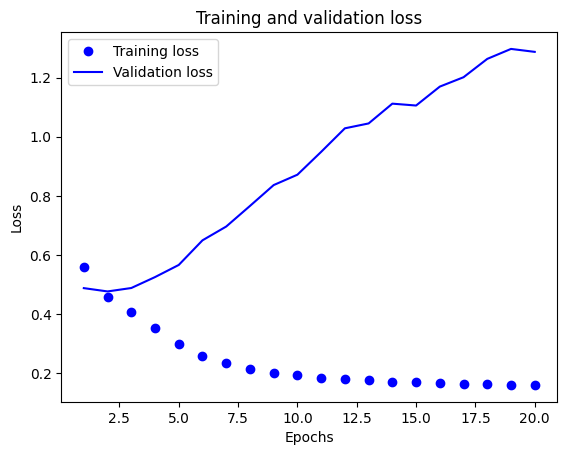

In [204]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss') # "bo"는 "파란색 점"
plt.plot(epochs, val_loss, 'b', label='Validation loss') # b는 "파란 실선"
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

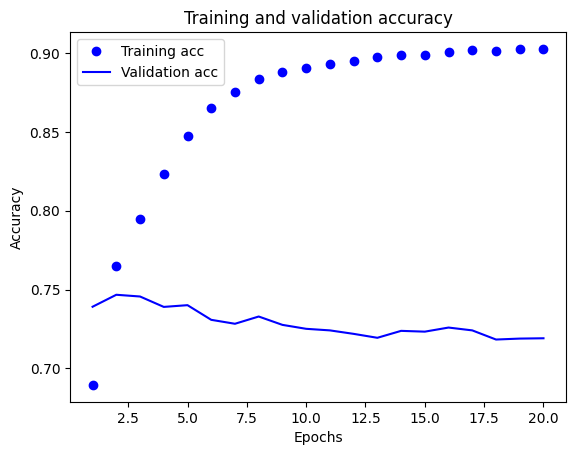

In [205]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 4.3) 3rd Model

외부 사이트에서 참고한 LSTM을 활용한 모델 정보로 학습을 수행해 보도록 하겠습니다. 

In [207]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model_3rd = Sequential()
model_3rd.add(Embedding(vocab_size, embedding_dim))
model_3rd.add(LSTM(hidden_units))
model_3rd.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model_3rd.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model_3rd.fit(partial_X_train, partial_y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_data=(X_val, y_val), verbose=2)

Epoch 1/15


2022-12-07 00:53:07.486588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-07 00:53:07.666041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-07 00:53:08.323632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-07 00:54:14.137334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-07 00:54:14.209362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_acc improved from -inf to 0.85220, saving model to best_model.h5
2116/2116 - 69s - loss: 0.3847 - acc: 0.8271 - val_loss: 0.3327 - val_acc: 0.8522 - 69s/epoch - 33ms/step
Epoch 2/15

Epoch 2: val_acc improved from 0.85220 to 0.85360, saving model to best_model.h5
2116/2116 - 62s - loss: 0.3199 - acc: 0.8620 - val_loss: 0.3252 - val_acc: 0.8536 - 62s/epoch - 29ms/step
Epoch 3/15

Epoch 3: val_acc improved from 0.85360 to 0.86510, saving model to best_model.h5
2116/2116 - 61s - loss: 0.2965 - acc: 0.8744 - val_loss: 0.3074 - val_acc: 0.8651 - 61s/epoch - 29ms/step
Epoch 4/15

Epoch 4: val_acc improved from 0.86510 to 0.86580, saving model to best_model.h5
2116/2116 - 63s - loss: 0.2811 - acc: 0.8819 - val_loss: 0.3084 - val_acc: 0.8658 - 63s/epoch - 30ms/step
Epoch 5/15

Epoch 5: val_acc did not improve from 0.86580
2116/2116 - 65s - loss: 0.2682 - acc: 0.8884 - val_loss: 0.3252 - val_acc: 0.8648 - 65s/epoch - 31ms/step
Epoch 6/15

Epoch 6: val_acc improved from 0.86580 to 

In [218]:
results = model_3rd.evaluate(X_test_pre,  y_test, verbose=2)
print(results)

1537/1537 - 13s - loss: 0.4613 - acc: 0.8378 - 13s/epoch - 8ms/step
[0.4613048732280731, 0.8378257155418396]


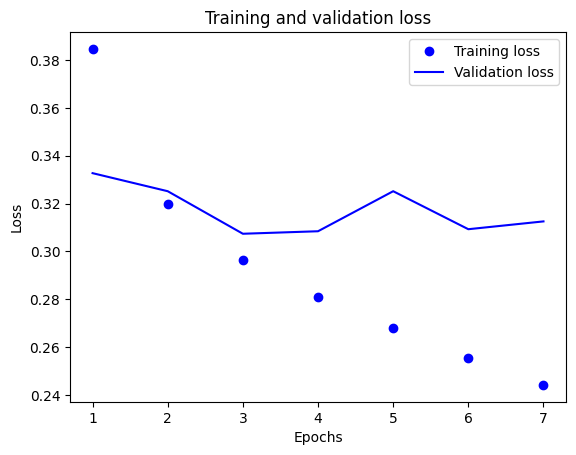

In [211]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss') # "bo"는 "파란색 점"
plt.plot(epochs, val_loss, 'b', label='Validation loss') # b는 "파란 실선"
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

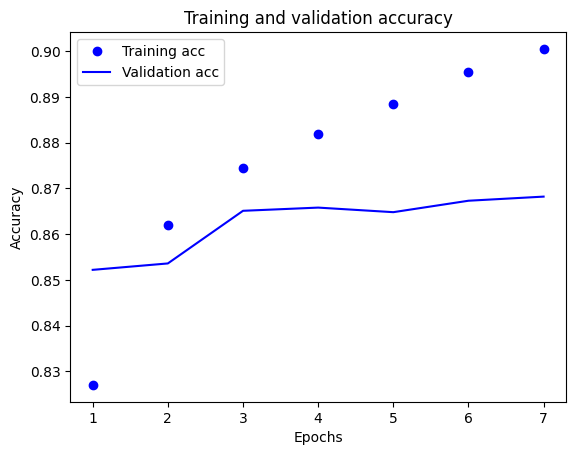

In [212]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

조기 종료로 충분히 데이터가 수렴하지 못한 것으로 판단되어 조기 종료 조건을 제외하고 다시 한번 실행해 보도록 하겠습니다.

### 4.4) 4th Model

In [51]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)

embedding_dim = 100
hidden_units = 128

model_4th = Sequential()
model_4th.add(Embedding(vocab_size, embedding_dim))
model_4th.add(LSTM(hidden_units))
model_4th.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model_4th.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

history = model_4th.fit(partial_X_train, partial_y_train, epochs=15, callbacks=[mc], batch_size=64, validation_data=(X_val, y_val), verbose=2)

Epoch 1/15


2022-12-07 19:42:27.032414: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-07 19:42:27.735920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-07 19:42:27.855721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-07 19:42:27.992928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-07 19:43:07.217851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-07 19:43:07.260788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_acc improved from -inf to 0.85110, saving model to best_model.h5
2116/2116 - 41s - loss: 0.3834 - acc: 0.8272 - val_loss: 0.3326 - val_acc: 0.8511 - 41s/epoch - 20ms/step
Epoch 2/15

Epoch 2: val_acc improved from 0.85110 to 0.85930, saving model to best_model.h5
2116/2116 - 40s - loss: 0.3214 - acc: 0.8613 - val_loss: 0.3226 - val_acc: 0.8593 - 40s/epoch - 19ms/step
Epoch 3/15

Epoch 3: val_acc improved from 0.85930 to 0.86190, saving model to best_model.h5
2116/2116 - 39s - loss: 0.2979 - acc: 0.8740 - val_loss: 0.3147 - val_acc: 0.8619 - 39s/epoch - 18ms/step
Epoch 4/15

Epoch 4: val_acc improved from 0.86190 to 0.86490, saving model to best_model.h5
2116/2116 - 40s - loss: 0.2820 - acc: 0.8819 - val_loss: 0.3087 - val_acc: 0.8649 - 40s/epoch - 19ms/step
Epoch 5/15

Epoch 5: val_acc improved from 0.86490 to 0.86880, saving model to best_model.h5
2116/2116 - 40s - loss: 0.2697 - acc: 0.8882 - val_loss: 0.3068 - val_acc: 0.8688 - 40s/epoch - 19ms/step
Epoch 6/15

Epoch 6

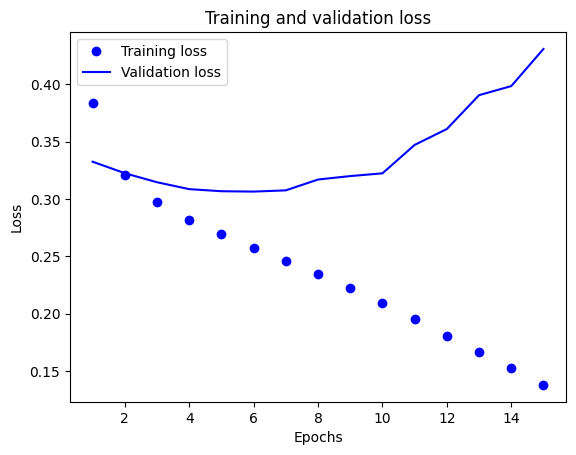

In [52]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss') # "bo"는 "파란색 점"
plt.plot(epochs, val_loss, 'b', label='Validation loss') # b는 "파란 실선"
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

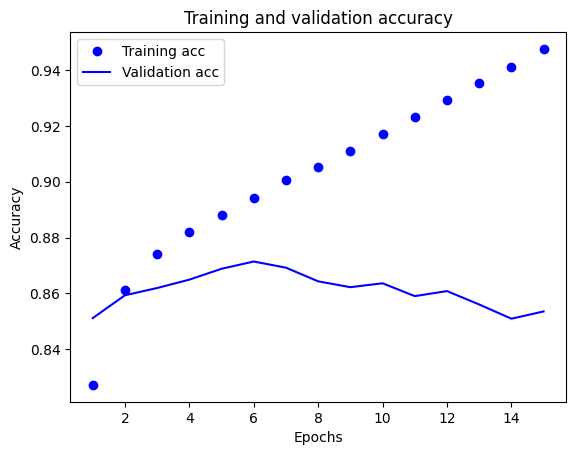

In [53]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [54]:
results = model_4th.evaluate(X_test_pre,  y_test, verbose=2)
print(results)

1527/1527 - 10s - loss: 0.4404 - acc: 0.8483 - 10s/epoch - 7ms/step
[0.44038599729537964, 0.8483378887176514]


In [55]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test_pre, y_test)[1]))

   7/1527 [..............................] - ETA: 12s - loss: 0.3507 - acc: 0.8750 

2022-12-07 19:52:32.290057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-12-07 19:52:32.333082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1527/1527 [==============================] - 11s 7ms/step - loss: 0.3136 - acc: 0.8666

 테스트 정확도: 0.8666


가장 좋은 모델 가중치로 test_data를 평가해 보니 정확도 86%가 나왔습니다. 

## 5) gensim과 한국어 Word2Vec을 활용

In [12]:
from gensim.models import Word2Vec
from gensim.models.keyedvectors import Word2VecKeyedVectors

In [13]:
model_filepath = '/Users/joowanha/PycharmProjects/AIFFEL/sentiment_classification/word2vec_ko.model'
model_wv = gensim.models.Word2Vec.load(model_filepath)

In [14]:
# 완성된 임베딩 매트릭스의 크기 확인
model_wv.wv.vectors.shape

(302960, 100)

In [15]:
print(model_wv.wv.most_similar("재미"))

[('묘미', 0.6163142919540405), ('취미', 0.6034970283508301), ('흥미', 0.5939850807189941), ('유머', 0.5888698697090149), ('보람', 0.5689517259597778), ('즐거움', 0.5631208419799805), ('개그', 0.5552945733070374), ('이야기', 0.5536993741989136), ('연애', 0.552293598651886), ('열의', 0.5464565753936768)]


In [16]:
print(model_wv.wv.most_similar("헐리우드"))

[('할리우드', 0.8523824214935303), ('영화', 0.7397844195365906), ('뮤지컬', 0.7288962602615356), ('브로드웨이', 0.7178134918212891), ('블록버스터', 0.6875178813934326), ('라스베가스', 0.6811758279800415), ('이스트우드', 0.6792123317718506), ('스탠드업', 0.6735172867774963), ('키튼', 0.6691097617149353), ('《》', 0.6584674715995789)]


### 5.1) 리뷰 예측해보기

In [58]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re

In [98]:
X_train_sen = get_decoded_sentences(X_train, index_to_word)
X_train_sen[:10]

['더 빙 진짜 짜증 나 네요 목소리',
 '포스터 보고 초딩 영화 줄 오버 연기 조차 가볍 지 않 구나',
 '재 ',
 '이야기 구먼 솔직히 재미 없 다 평점 조정',
 '익살 스런 연기 돋보였 던 영화 스파이더맨 에서 늙 어 보이 기 만 했 던   너무나 이뻐 보였 다',
 '  세 부터 초등 학교 학년 생 인  영화 ㅋㅋㅋ 별반 개 아까움',
 '긴장감 을 제대로 살려 내 지 못했 다',
 '반개 아깝 다 욕 나온다   연기 생활 몇 년 인지 정말 발 로 해도 그것 보단 낫 겟 다 납치 감금 만 반복 반복 드라마 가족 없 다 연기 못 하 사람 만  네',
 '없 는데 재미 있 몇 안 되 영화',
 '케 평점 낮 건데 꽤 볼 만 한데 헐리우드 식 화려 함 만 너무  있 나']

In [99]:
tokenizer_pre = Tokenizer(vocab_size) 
tokenizer_pre.fit_on_texts(X_train_sen)

In [103]:
def sentiment_predict(new_sentence):
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
    new_sentence = tokenizer.morphs(new_sentence) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer_pre.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = maxlen) # 패딩
    score = float(model_4th.predict(pad_new)) # 예측
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [104]:
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ')

1/1 [==============================] - 0s 21ms/step
51.96% 확률로 긍정 리뷰입니다.



In [109]:
sentiment_predict('개꿀잼 ㅋㅋㅋ')

1/1 [==============================] - 0s 21ms/step
60.05% 확률로 부정 리뷰입니다.



In [105]:
sentiment_predict('이 영화 핵노잼 ㅠㅠ')

1/1 [==============================] - 0s 21ms/step
98.50% 확률로 부정 리뷰입니다.



In [106]:
sentiment_predict('이 영화 재미있습니다.')

1/1 [==============================] - 0s 16ms/step
80.60% 확률로 긍정 리뷰입니다.



## 회고
 - 학습한 모델을 가지고 각 단어간 vector 값 추출 및 위치 비교를 해보고 싶었으나, 방법을 찾지 못해 아쉬움이 남습니다. 해당 방법은 추후에 다시 확인해 보도록 하겠습니다. 
 - LSTM을 활용한 단순한 모델링에서의 정확도가 매우 높게 나타났습니다. LSTM에 자연어 학습에 있어 높은 성능을 보여 주는 것을 확인할 수 있었습니다.
 - 긍부정 예측이 비교적 유사하게 나왔으나 첫 번째 시도인 "이 영화 개꿀잼 ㅋㅋㅋ"의 경우 간신히 긍정이 나와 좀 더 정확성을 높일 필요성이 있을 것 같습니다. 초반에 확인한 긍부정 값이 잘 못 들어간 항목에 대한 영향도 어느 정도 존재하리라 예상됩니다. 

## 참고
- pad_sequences (pre vs. post) : https://biology-statistics-programming.tistory.com/42
- https://wikidocs.net/44249